In [39]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from skimage import img_as_float,data
from skimage.segmentation import chan_vese

https://www.kaggle.com/antocad/siim-isic-image-preprocessing-dull-razor

In [3]:
def dullrazor(img, lowbound=15, showimgs=True, filterstruc=3, inpaintmat=3):
    #grayscale
    imgtmp1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #applying a blackhat
    filterSize =(filterstruc, filterstruc)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filterSize) 
    imgtmp2 = cv2.morphologyEx(imgtmp1, cv2.MORPH_BLACKHAT, kernel)

    #0=skin and 255=hair
    ret, mask = cv2.threshold(imgtmp2, lowbound, 255, cv2.THRESH_BINARY)
    
    #inpainting
    img_final = cv2.inpaint(img, mask, inpaintmat ,cv2.INPAINT_TELEA)
    
    if showimgs:
        print("_____DULLRAZOR_____")
        plt.imshow(imgtmp1, cmap="gray")
        plt.show()
        plt.imshow(imgtmp2, cmap='gray')
        plt.show()
        plt.imshow(mask, cmap='gray')
        plt.show()
        plt.imshow(img_final)
        plt.show()
        print("___________________")

    return img_final

In [4]:
def show_image(img):
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

# Load image

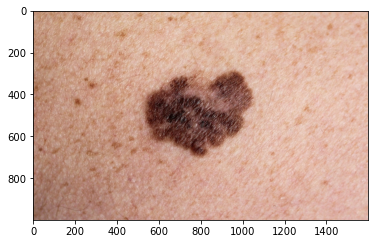

In [5]:
img=cv2.imread("input_image.jpeg")
show_image(img)

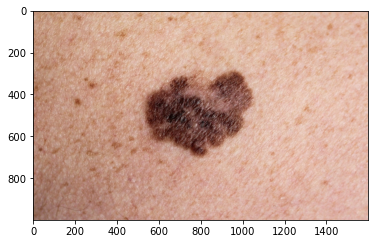

In [6]:
img2=dullrazor(img,showimgs=False)
show_image(img2)

# Otsu Thresholding

In [7]:
def otsu(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img,(5,5),0)
    # find normalized_histogram, and its cumulative distribution function
    hist = cv2.calcHist([blur],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.sum()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    list_x=list()
    list_within_variance=list()
    for i in range(1,256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        if q1 < 1.e-6 or q2 < 1.e-6:
            continue
        b1,b2 = np.hsplit(bins,[i]) # weights
        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
        list_x.append(i)
        list_within_variance.append(fn)
    # find otsu's threshold value with OpenCV function
    ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print( "{} {}".format(thresh,ret) )

    plt.plot(hist_norm)
    plt.show()
    plt.plot(list_x,list_within_variance)
    plt.savefig("withinClassVariance.png")
    plt.show()

    return ret, hist_norm, list_x,list_within_variance

144 144.0


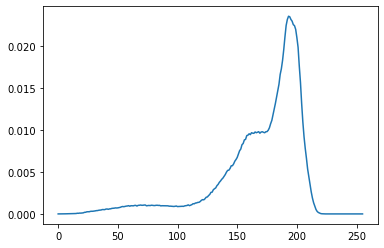

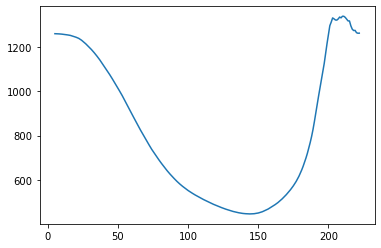

In [8]:
ret,hist_norm,list_x,list_within_variance=otsu(img2)

In [9]:
thresh,binary_image=cv2.threshold(cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY),145,255,cv2.THRESH_BINARY_INV)
# show_image(binary_image)
cv2.imwrite("output_binarymask.jpg",binary_image)

True

In [10]:
cv2.imwrite("input_gray.jpg",cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY))

True

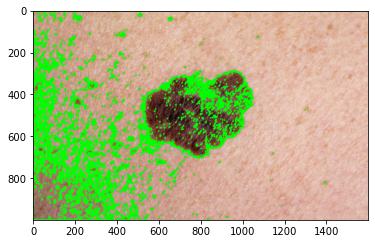

In [11]:
temp_img=img2.copy()
contours, hierarchy=cv2.findContours(binary_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
cv2.drawContours(temp_img,contours,-1,(0,255,0),5)
cv2.imwrite("image_w_all_contours.jpg",temp_img)
show_image(temp_img)

In [12]:
# contours, hierarchy=cv2.findContours(binary_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
max_contour=max(contours,key=cv2.contourArea)

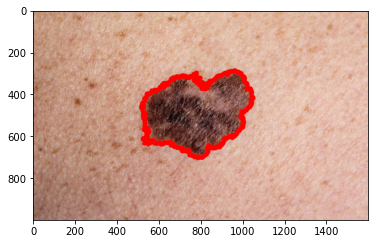

In [13]:
temp_img=img2.copy()
cv2.drawContours(temp_img,max_contour,-1,(0,0,255),20)
cv2.imwrite("image_w_contour.jpg",temp_img)
show_image(temp_img)

In [14]:
hh,ww=img2.shape[0:2]
mask=np.zeros((hh,ww),dtype=np.uint8)
cv2.drawContours(mask, [max_contour], 0, (255,255,255), cv2.FILLED)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [15]:
cropped_result=cv2.bitwise_and(img2,img2,mask=mask)
cv2.imwrite("cropped_result.jpg",cropped_result)

True

# A Asymmetry

## Area Asymmetry

In [16]:
xc,yc=max_contour.mean(axis=0).astype(int)[0]

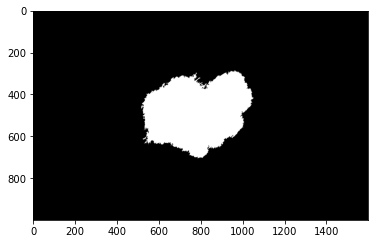

In [17]:
show_image(mask)

In [18]:
mask2=mask.copy()
mask2=cv2.cvtColor(mask2,cv2.COLOR_GRAY2BGR)
cv2.drawContours(mask2,max_contour,-1,(0,0,255),10)
cv2.imwrite("a_mask_contourline.jpg",mask2)

True

## split upper-lower mask, left-right mask

In [19]:
mask_left=mask[:,:xc]
mask_right=mask[:,xc:]
mask_upper=mask[:yc,:]
mask_lower=mask[yc:,:]
print(mask_left.shape,mask_right.shape,mask_upper.shape,mask_lower.shape)

min_leftright=min(mask_left.shape[1],mask_right.shape[1])
mask_left=mask_left[:,-min_leftright:]
mask_right=mask_right[:,:min_leftright]

min_updown=min(mask_upper.shape[0],mask_lower.shape[0])
mask_upper=mask_upper[-min_updown:,:]
mask_lower=mask_lower[:min_updown,:]

print(mask_left.shape,mask_right.shape,mask_upper.shape,mask_lower.shape)

cv2.imwrite("a_mask_left.jpg",mask_left)
cv2.imwrite("a_mask_right.jpg",mask_right)
cv2.imwrite("a_mask_upper.jpg",mask_upper)
cv2.imwrite("a_mask_lower.jpg",mask_lower)

(1000, 768) (1000, 832) (475, 1600) (525, 1600)
(1000, 768) (1000, 768) (475, 1600) (475, 1600)


True

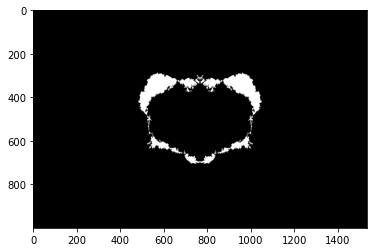

(1000, 1536)

In [20]:
mask_fold_leftright=np.append(cv2.bitwise_xor(mask_left,mask_right[:,::-1]),cv2.bitwise_xor(mask_left[:,::-1],mask_right),axis=1)
show_image(mask_fold_leftright)
mask_fold_leftright.shape

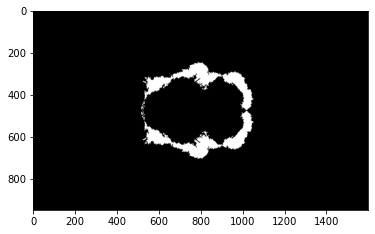

(950, 1600)

In [21]:
mask_fold_updown=np.append(cv2.bitwise_xor(mask_upper,mask_lower[::-1,:]),cv2.bitwise_xor(mask_upper[::-1,:],mask_lower),axis=0)
show_image(mask_fold_updown)
mask_fold_updown.shape

In [22]:
cv2.imwrite("a_mask_fold_vertical.jpg",mask_fold_leftright)
cv2.imwrite("a_mask_fold_horizon.jpg",mask_fold_updown)

True

## calculate area

In [23]:
np.sum(mask_fold_leftright//255)/np.sum(mask//255)

0.2955148275930838

In [24]:
np.sum(mask_fold_updown//255)/np.sum(mask//255)

0.3863749675926849

## color asymmetry

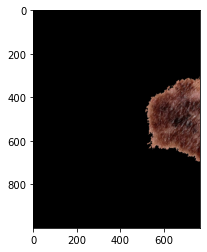

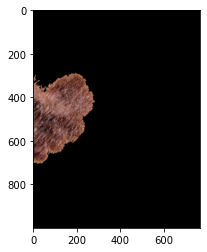

True

In [25]:
show_image(cropped_result[:,xc-min_leftright:xc])
show_image(cropped_result[:,xc:xc+min_leftright])
cv2.imwrite("a_left.jpg",cropped_result[:,xc-min_leftright:xc])
cv2.imwrite("a_right.jpg",cropped_result[:,xc:xc+min_leftright])

In [26]:
cv2.pointPolygonTest(max_contour,(700,500),False)
hh,ww
for i in range(hh):
    for j in range(ww):
        if cv2.pointPolygonTest(max_contour,(i,j),False)<0:
            continue;
        print(i,j)

989 562
989 563
989 564
989 565
989 566
989 567
990 300
990 301
990 302
990 303
990 304
990 305
990 306
990 307
990 308
990 309
990 310
990 311
990 312
990 313
990 314
990 315
990 316
990 317
990 318
990 319
990 320
990 321
990 322
990 323
990 324
990 325
990 326
990 327
990 328
990 329
990 330
990 331
990 332
990 333
990 334
990 335
990 336
990 337
990 338
990 339
990 340
990 341
990 342
990 343
990 344
990 345
990 346
990 347
990 348
990 349
990 350
990 351
990 352
990 353
990 354
990 355
990 356
990 357
990 358
990 359
990 360
990 361
990 362
990 363
990 364
990 365
990 366
990 367
990 368
990 369
990 370
990 371
990 372
990 373
990 374
990 375
990 376
990 377
990 378
990 379
990 380
990 381
990 382
990 383
990 384
990 385
990 386
990 387
990 388
990 389
990 390
990 391
990 392
990 393
990 394
990 395
990 396
990 397
990 398
990 399
990 400
990 401
990 402
990 403
990 404
990 405
990 406
990 407
990 408
990 409
990 410
990 411
990 412
990 413
990 414
990 415
990 416
990 417
990 418


In [27]:
r_bins = 5
g_bins = 5
b_bins = 5
histSize = [b_bins, g_bins, r_bins]
range_hist=[0,256]*3
hist_left=cv2.calcHist([cropped_result[:,xc-min_leftright:xc]],[0,1,2],mask_left,histSize,range_hist,accumulate=False)
hist_right=cv2.calcHist([cropped_result[:,xc:xc+min_leftright]],[0,1,2],mask_right,histSize,range_hist,accumulate=False)

In [28]:
cropped_result[:,xc-min_leftright:xc].shape

(1000, 768, 3)

In [29]:
mask_left.shape

(1000, 768)

In [30]:
hist_left.shape

(5, 5, 5)

In [31]:
hist_right.shape

(5, 5, 5)

In [32]:
cv2.compareHist(hist_left,hist_right,cv2.HISTCMP_CHISQR_ALT)

29535.535262487378

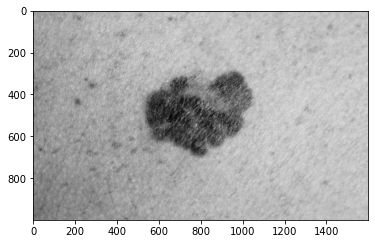

In [36]:
show_image(cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY))

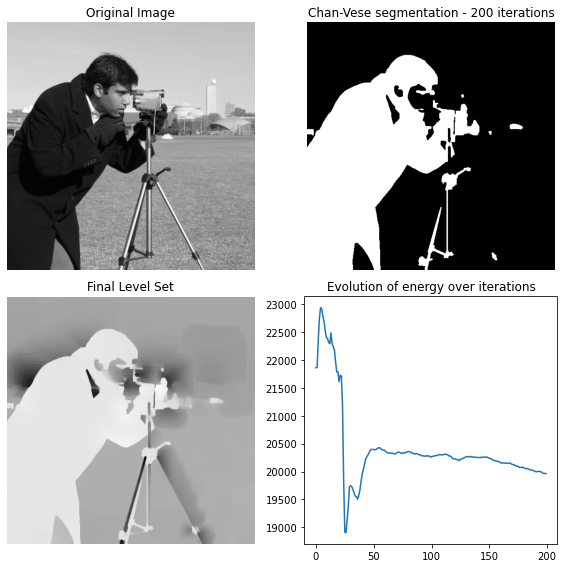

In [42]:
# cv = chan_vese(cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY), mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
#                dt=0.5, init_level_set="checkerboard", extended_output=True)

temp_image=img_as_float(data.camera())

cv = chan_vese(temp_image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(temp_image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()